In [1]:
import data_preprocess_functions as dp_f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
#from sklearn.utils import shuffle

from tensorflow.keras.utils import to_categorical

from tensorflow.keras import Model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import math

In [7]:
Dir='/nfs/kloe/einstein4/martino/'
mode='VariableCone'
path=Dir+'PKL/Zprime'+mode+'/singleBJetnocut/'#'/singleBJetnocut/'


In [8]:
X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat=dp_f.retrieve_dataset(path)

In [409]:
N=y_train.shape[0]
f=(y_train[np.where(y_train==1)].shape[0],y_train[np.where(y_train==0)].shape[0])

In [410]:
μ_s=np.array([])
σ_s=np.array([])
μ_b=np.array([])
σ_b=np.array([])
for i in range(6):
    μ_s=np.append(μ_s,X_train[np.where(y_train==1),i].mean())
    σ_s=np.append(σ_s,X_train[np.where(y_train==1),i].std())
    μ_b=np.append(μ_b,X_train[np.where(y_train==0),i].mean())
    σ_b=np.append(σ_b,X_train[np.where(y_train==0),i].std())
    #print(i,X_train[:,i].mean(),X_train[:,i].std())
#print(μ,σ)

In [411]:
def integral(y,x,bins):
    x_min=x
    s=0
    for i in np.where(bins>x)[0][:-1]:
#        s=s+y[i]*(bins[i+1]-bins[i])
#        print(i,s)
        s=s+y[i]*(bins[i+1]-bins[i])
    return s

In [412]:
def gauss(x,μ,σ):
    return (1./math.sqrt(2*math.pi*σ**2))*math.exp(-0.5*((x-μ)**2)/σ**2)

gauss_v=np.vectorize(gauss)

In [413]:
def eff_calc(LLR_s,bins_s,LLR_b,bins_b):
    N_s=integral(LLR_s,-100,bins_s)
    N_b=integral(LLR_b,-100,bins_b)

    signal_eff=np.array([])
    bkg_eff=np.array([])
    y_s=0
    y_n=0

    precision=1e3
    x0,x1=min(bins_s[0],bins_b[0])-1,max(bins_s[-1],bins_b[-1])+1
    X_int=np.arange(int(round(precision*x0)),int(round(precision*x1)))/precision
    for x in X_int:
        y_s=integral(LLR_s,x,bins_s)/N_s
        y_n=integral(LLR_b,x,bins_b)/N_b
        signal_eff=np.append(y_s,signal_eff)
        bkg_eff=np.append(y_n,bkg_eff)

    #Area=round(1000*integral(signal_eff,0)/Nbins)/1000
    Area=round(1000*abs(integral(signal_eff,0,bkg_eff)))/1000
    return signal_eff,bkg_eff,Area

In [414]:
def TF_curve(bkg_eff,signal_eff,Area):
    lab='Area: '+str(Area)
    plt.plot(bkg_eff,signal_eff,label=lab)
    plt.plot([0,1],[0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.xlim([0.001,1])
    #plt.yscale('log')
    plt.title('ROC curve')
    plt.legend()
    #plt.savefig('ROC_'+MVA_model_name+'.pdf')
    plt.show()

In [415]:
def ROC(bkg_eff,signal_eff):
    WP=[0.90,0.94,0.97,0.99]
    rej=1./bkg_eff
    WP_idx=[np.where(np.abs(signal_eff-WP[i])==np.min(np.abs(signal_eff-WP[i])))[0][0] for i in range(0,len(WP))]
    #rej[WP_idx]
    WP_rej=[str(round(10*rej[WP_idx[i]])/10) for i in range(0,len(WP))]
    print(WP_rej)

    plt.plot(signal_eff,rej)
    for i in range(0,len(WP)):
        plt.axvline(x=WP[i],color='Red',linestyle='dashed',label='Bkg Rejection @ '+str(WP[i])+' WP: '+WP_rej[i])
    plt.xlabel('Signal efficiency')
    plt.ylabel('Background rejection')
    plt.xlim([0.75,1])
    plt.yscale('log')
    plt.title('ROC curve')
    plt.legend()
    #        plt.savefig('rejection_ROC_'+MVA_model_name+'.pdf')
    plt.show()

In [419]:
train_logLikelihood=np.array([])
acc=0

N=10000
for s in range(N):

    P_s=1
    P_b=1
    for i in range(6):
        P_s=P_s*gauss(X_train[s,i],μ_s[i],σ_s[i])
        P_b=P_b*gauss(X_train[s,i],μ_b[i],σ_b[i])

    P_s=P_s*f[0]/(f[0]+f[1])
    P_b=P_b*f[1]/(f[0]+f[1])
    if (P_s/P_b>=1. and y_train[s]==1) or (P_s/P_b<1. and y_train[s]==0):
        acc=acc+1

    
    train_logLikelihood=np.append(train_logLikelihood,math.log(P_s/P_b))
    print(format(float(s/N),'02'),end='')
    print('\r', end='')
    #P_s,P_b,y_train[s]
print(acc/N)

0.8223


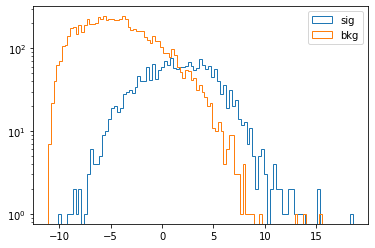

In [420]:
Nbins=100
LLR_s,bins_s,_=plt.hist(train_logLikelihood[np.where(y_train[:N]==1)[0]],bins=Nbins,label='sig',histtype='step')
LLR_b,bins_b,_=plt.hist(train_logLikelihood[np.where(y_train[:N]==0)[0]],bins=Nbins,label='bkg',histtype='step')
plt.yscale('log')
plt.legend()
plt.show()

In [421]:
signal_eff,bkg_eff,Area=eff_calc(LLR_s,bins_s,LLR_b,bins_b)

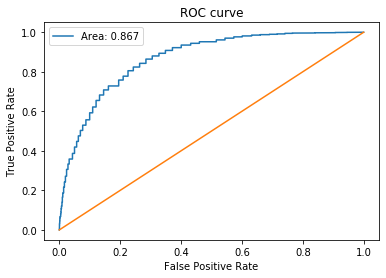

In [422]:
TF_curve(bkg_eff,signal_eff,Area)

/afs/le.infn.it/user/c/centonze/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


['3.1', '2.3', '1.8', '1.4']


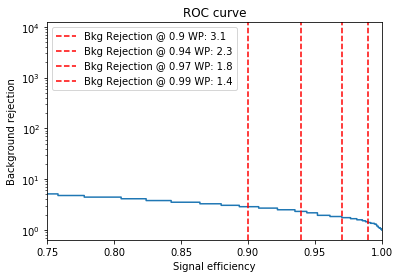

In [423]:
ROC(bkg_eff,signal_eff)

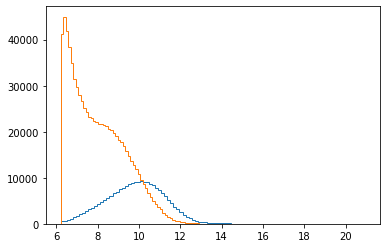

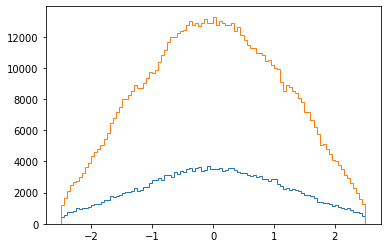

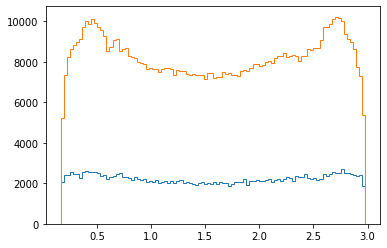

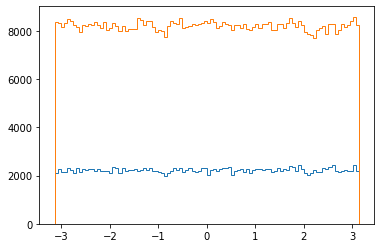

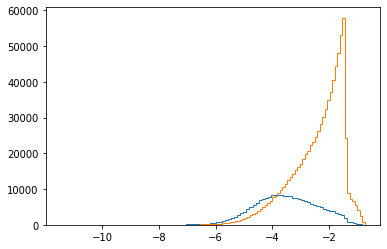

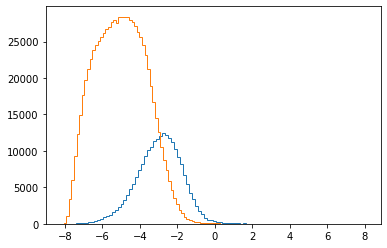

In [440]:
xhs=np.array([])
bhs=np.array([])
xhb=np.array([])
bhb=np.array([])

for i in range(0,6):
    tmp_xhs,tmp_bhs,_=plt.hist(X_train[np.where(y_train==1),i][0],bins=100,histtype='step')
    tmp_xhb,tmp_bhb,_=plt.hist(X_train[np.where(y_train==0),i][0],bins=100,histtype='step')
    plt.show()
    if i==0:
        xhs=tmp_xhs
        bhs=tmp_bhs
        xhb=tmp_xhb
        bhb=tmp_bhb
    if i>0:
        xhs=np.vstack((xhs,tmp_xhs))
        bhs=np.vstack((bhs,tmp_bhs))
        xhb=np.vstack((xhb,tmp_xhb))
        bhb=np.vstack((bhb,tmp_bhb))
    


In [441]:
def K_gauss(x,α,fh,bh):
    s=0
    M=fh.shape[0]
    for k in range(M):
        s=s+fh[k]*gauss_v(x,bh[k],α)
    return s/M

#K_gauss_v=np.vectorize(K_gauss)

In [442]:
X=np.stack([np.linspace(5,20.15,Nbins),np.linspace(-3,3,Nbins),np.linspace(0,3,Nbins),np.linspace(-3.5,3.5,Nbins),np.linspace(-12,0,Nbins),np.linspace(-9,9,Nbins)],axis=0)

In [443]:
X.shape

(6, 100)

2144.701136102053 6434.390828172047


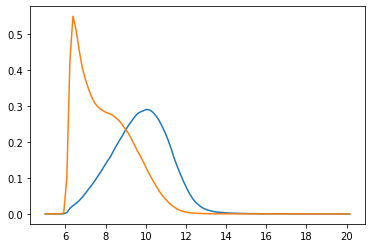

1838.010723006742 6777.17914686853


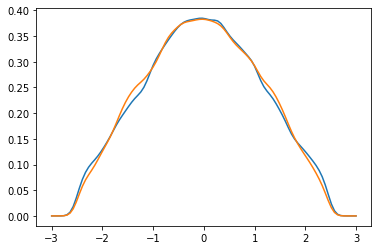

2053.5927408227226 7580.196885143545


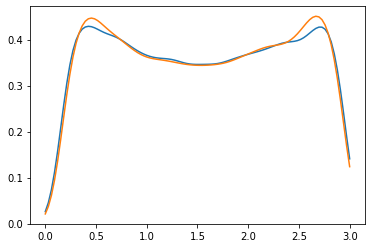

1979.912442742733 7299.8264414621735


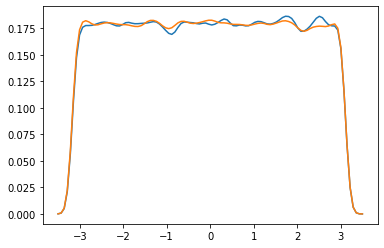

1969.0715955920236 5973.471707413858


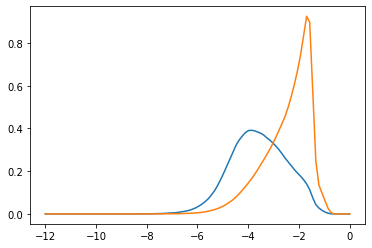

1949.9663647625684 6298.6821222669305


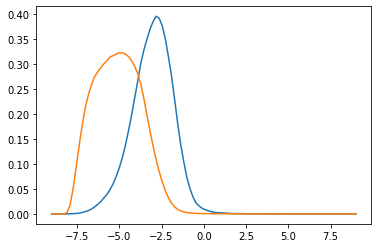

In [444]:
α=0.1

Ns_v=np.array([])
Nb_v=np.array([])
for i in range(0,6):
    
    Ns=integral(K_gauss(X[i],α,xhs[i],bhs[i]),X[i,0],bhs[i])
    Nb=integral(K_gauss(X[i],α,xhb[i],bhb[i]),X[i,0],bhb[i])
    print(Ns,Nb)
    Ns_v=np.append(Ns_v,Ns)
    Nb_v=np.append(Nb_v,Nb)
    plt.plot(X[i],K_gauss(X[i],α,xhs[i],bhs[i])/Ns)
    plt.plot(X[i],K_gauss(X[i],α,xhb[i],bhb[i])/Nb)
    #plt.yscale('log')
    plt.show()

In [457]:
train_logLikelihood_K=np.array([])
acc=0

N=10000
for s in range(N):

    P_s=1
    P_b=1
    for i in range(6):
        P_s=P_s*K_gauss(X_train[s,i],α,xhs[i],bhs[i])/Ns_v[i]
        P_b=P_b*K_gauss(X_train[s,i],α,xhb[i],bhb[i])/Nb_v[i]
    
    P_s=P_s*f[0]/(f[0]+f[1])
    P_b=P_b*f[1]/(f[0]+f[1])
    if (P_s/P_b>=1. and y_train[s]==1) or (P_s/P_b<1. and y_train[s]==0):
        acc=acc+1
    
    train_logLikelihood_K=np.append(train_logLikelihood_K,math.log(P_s/P_b))
    print(format(float(s/N),'02'),end='')
    print('\r', end='')
    #P_s,P_b,y_train[s]
print(acc/N)

0.8349


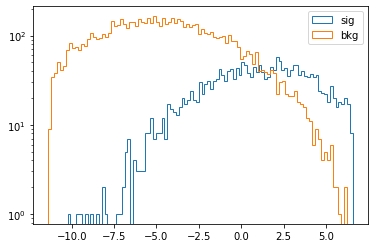

In [458]:
Nbins=100
LLR_s_K,bins_s_K,_=plt.hist(train_logLikelihood_K[np.where(y_train[:N]==1)[0]],bins=Nbins,label='sig',histtype='step')
LLR_b_K,bins_b_K,_=plt.hist(train_logLikelihood_K[np.where(y_train[:N]==0)[0]],bins=Nbins,label='bkg',histtype='step')
plt.yscale('log')
plt.legend()
plt.show()

In [459]:
signal_eff_K,bkg_eff_K,Area_K=eff_calc(LLR_s_K,bins_s_K,LLR_b_K,bins_b_K)

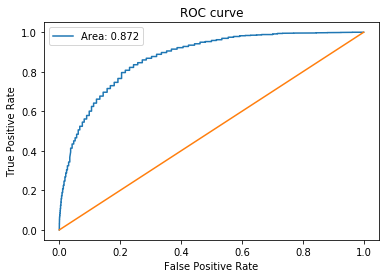

In [460]:
TF_curve(bkg_eff_K,signal_eff_K,Area_K)

/afs/le.infn.it/user/c/centonze/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


['3.0', '2.3', '1.9', '1.4']


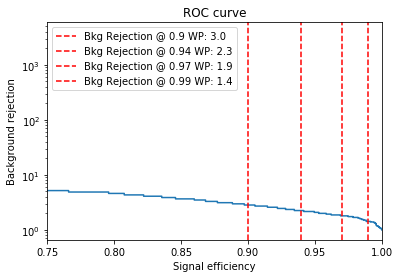

In [461]:
ROC(bkg_eff_K,signal_eff_K)

In [424]:
from sklearn.decomposition import PCA, KernelPCA

In [425]:
def n(cut):
    k=0
    s=pca.explained_variance_ratio_[k]

    while s<cut:
        k=k+1
        s=s+pca.explained_variance_ratio_[k]
        
    return s,k+1

In [426]:
columns_list=['trk_log_pt', 'trk_eta', 'theta', 'phi', 'log_dr', 'log_ptfrac']

Explained variance ratio: [0.43894691 0.29023937 0.17200281 0.06737572 0.03060897 0.00082621]


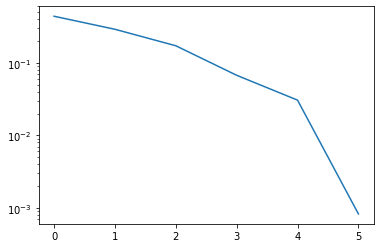

In [446]:
pca = PCA()

pca.fit(X_train[:10000])
u=pca.components_#eigen_v
X_pca=pca.transform(X_train[:10000])

print('Explained variance ratio: %s'
      % str(pca.explained_variance_ratio_))
plt.plot(pca.explained_variance_ratio_)
plt.yscale('log')

(0.9991737882789494, 5)


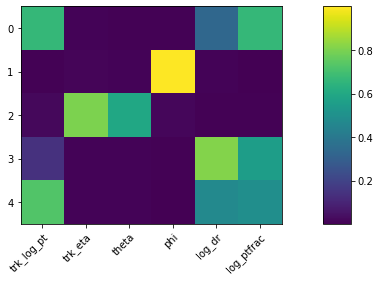

In [447]:
e=0.99
n_feats=n(e)[1]
print(n(e))

fig, ax = plt.subplots(1,figsize=(15,4))
im = ax.imshow(np.abs(u[:n_feats]))
ax.set_xticks(np.arange(len(columns_list)))
ax.set_xticklabels(columns_list)
ax.set_yticks(np.arange(n_feats))
ax.set_yticklabels(np.arange(n_feats))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax, orientation='vertical', aspect=8)
plt.show()

In [452]:
def z(x):
#    return np.concatenate((u_1@x,u_0@x)).astype('float32')
    return u@x

def z_v(X):
    zv_m=z(X[0,:])
    for i in range(1,X.shape[0]):
        zv_m=np.vstack( (zv_m,z(X[i,:])) )
        
        print(float(i/X.shape[0]),end='')
        print('\r', end='')  
    
    print('Done  ',end='')
        
    return zv_m

In [453]:
z_train=z_v(X_train[:10000])

Done  

In [434]:
μ_s=np.array([])
σ_s=np.array([])
μ_b=np.array([])
σ_b=np.array([])
for i in range(6):
    μ_s=np.append(μ_s,z_train[np.where(y_train[:10000]==1),i].mean())
    σ_s=np.append(σ_s,z_train[np.where(y_train[:10000]==1),i].std())
    μ_b=np.append(μ_b,z_train[np.where(y_train[:10000]==0),i].mean())
    σ_b=np.append(σ_b,z_train[np.where(y_train[:10000]==0),i].std())
    #print(i,X_train[:,i].mean(),X_train[:,i].std())
#print(μ,σ)

In [435]:
train_logLikelihood_PCA=np.array([])
acc=0

N=10000
for s in range(N):

    P_s=1
    P_b=1
    for i in range(6):
        P_s=P_s*gauss(z_train[s,i],μ_s[i],σ_s[i])
        P_b=P_b*gauss(z_train[s,i],μ_b[i],σ_b[i])

    P_s=P_s*f[0]/(f[0]+f[1])
    P_b=P_b*f[1]/(f[0]+f[1])
    if (P_s/P_b>=1. and y_train[s]==1) or (P_s/P_b<1. and y_train[s]==0):
        acc=acc+1

    
    train_logLikelihood_PCA=np.append(train_logLikelihood_PCA,math.log(P_s/P_b))
    print(format(float(s/N),'02'),end='')
    print('\r', end='')
    #P_s,P_b,y_train[s]
print(acc/N)

0.8446


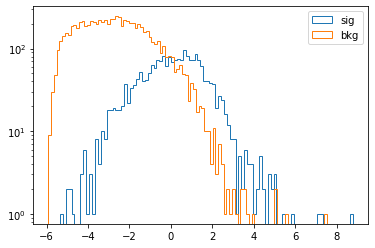

In [436]:
Nbins=100
LLR_s_PCA,bins_s_PCA,_=plt.hist(train_logLikelihood_PCA[np.where(y_train[:10000]==1)[0]],bins=Nbins,label='sig',histtype='step')
LLR_b_PCA,bins_b_PCA,_=plt.hist(train_logLikelihood_PCA[np.where(y_train[:10000]==0)[0]],bins=Nbins,label='bkg',histtype='step')
plt.yscale('log')
plt.legend()
plt.show()

In [437]:
signal_eff_PCA,bkg_eff_PCA,Area_PCA=eff_calc(LLR_s_PCA,bins_s_PCA,LLR_b_PCA,bins_b_PCA)

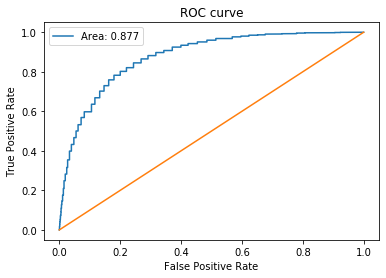

In [438]:
TF_curve(bkg_eff_PCA,signal_eff_PCA,Area_PCA)

/afs/le.infn.it/user/c/centonze/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


['3.2', '2.4', '1.9', '1.5']


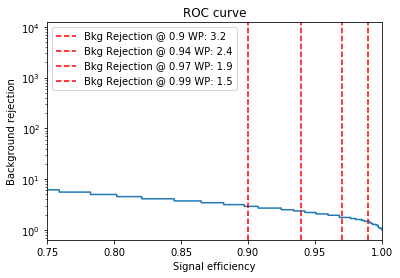

In [439]:
ROC(bkg_eff_PCA,signal_eff_PCA)